# <center >CS6700: Reinforcement Learning
## <center >Programming Assignment 2
## <center> DQN \& AC: Part 4 - AC Cartpole
###  Submitted by: 
### Gautham Govind A: EE19B022
### Vishnu Vinod: CS19B048 

## Importing Libraries

In [1]:
'''
Installing packages for rendering the game on Colab
'''
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1
!pip install gym[classic_control]

Requirement already up-to-date: setuptools in /home/vishnu/.local/lib/python3.8/site-packages (67.6.0)
  Ignoring pygame: markers 'extra == "classic-control"' don't match your environment


In [2]:
import scipy
import numpy as np
import random
import torch
import torch.nn as nn  
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp
import seaborn as sns
from tqdm import tqdm

2023-03-24 15:37:42.226382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-24 15:37:43.354834: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/vishnu/.local/lib/python3.8/site-packages/cv2/../../lib64:
2023-03-24 15:37:43.354994: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/vishnu/.local/lib/python3.8/site-packages/cv2/../../lib64:


## CartPole-v1

In [3]:
env = gym.make('CartPole-v1')

state_shape = env.observation_space.shape[0]
no_of_actions = env.action_space.n

print(state_shape, no_of_actions)
print(env.action_space.sample())

4 2
0


## AC Model

**Actor-Critic methods** learn both a policy $\pi(a|s;\theta)$ and a state-value function $v(s;w)$ simultaneously. The policy is referred to as the actor that suggests actions given a state. The estimated value function is referred to as the critic. It evaluates actions taken by the actor based on the given policy. In this exercise, both functions are approximated by feedforward neural networks. 

- The policy network is parametrized by $\theta$ - it takes a state $s$ as input and outputs the probabilities $\pi(a|s;\theta)\ \forall\ a$
- The value network is parametrized by $w$ - it takes a state $s$ as input and outputs a scalar value associated with the state, i.e., $v(s;w)$
- The loss function to be minimized at every step ($L_{tot}^{(t)}$) is a summation of two terms, as follows:
$$L_{tot}^{(t)} = L_{actor}^{(t)} + L_{critic}^{(t)}$$
where,
$$L_{actor}^{(t)} = -\log\pi(a_t|s_t; \theta)\delta_t$$
$$L_{critic}^{(t)} = \delta_t^2$$

- **NOTE: Here, weights of the first two hidden layers are shared by the policy and the value network**
    - Default hidden layer sizes: [1024, 512]
    - Output size of policy network: 2 (Softmax activation)
    - Output size of value network: 1 (Linear activation)

$$\pi(a|s;\theta) = \phi_{\theta}(a,s)$$

In [4]:
class ActorCriticModel(tf.keras.Model):
    """
    Defining policy and value networkss
    """
    def __init__(self, action_size, n_hidden1=1024, n_hidden2=512):
        super(ActorCriticModel, self).__init__()

        #Hidden Layer 1
        self.fc1 = tf.keras.layers.Dense(n_hidden1, activation='relu')
        #Hidden Layer 2
        self.fc2 = tf.keras.layers.Dense(n_hidden2, activation='relu')
        
        #Output Layer for policy
        self.pi_out = tf.keras.layers.Dense(action_size, activation='softmax')
        #Output Layer for state-value
        self.v_out = tf.keras.layers.Dense(1)

    def call(self, state):
        """
        Computes policy distribution and state-value for a given state
        """
        layer1 = self.fc1(state)
        layer2 = self.fc2(layer1)

        pi = self.pi_out(layer2)       # policy network outputs
        v = self.v_out(layer2)         # value network outputs

        return pi, v

## Agent 1: One-Step AC

- The single step TD error can be defined as follows:
$$\delta_t  = R_{t+1} + \gamma v(s_{t+1};w) - v(s_t;w)$$

In [5]:
class Agent1:
    """
    Agent class
    """
    def __init__(self, action_size, lr=1e-4, gamma=0.99, seed = 85, h1 = 1024, h2 = 512):
        self.gamma = gamma
        self.ac_model = ActorCriticModel(action_size, h1, h2)
        self.ac_model.compile(tf.keras.optimizers.Adam(learning_rate=lr))
        np.random.seed(seed)
    
    # Given a state, compute the policy distribution over all actions and sample one action
    def sample_action(self, state):
        pi,_ = self.ac_model(state)
        action_probabilities = tfp.distributions.Categorical(probs=pi)
        sample = action_probabilities.sample()
        return int(sample.numpy()[0])

    # actor loss
    def actor_loss(self, action, pi, delta):
        return -tf.math.log(pi[0,action]) * delta

    # critic loss
    def critic_loss(self,delta):
        return delta**2

    @tf.function
    # For a given transition (s,a,s',r) update the paramters
    def learn(self, state, action, reward, next_state, done):
        with tf.GradientTape(persistent=True) as tape:
            pi, V_s = self.ac_model(state)
            _, V_s_next = self.ac_model(next_state)

            V_s = tf.squeeze(V_s)
            V_s_next = tf.squeeze(V_s_next)
            

            # Equation for TD error
            delta = reward + self.gamma*V_s_next - V_s
            loss_a = self.actor_loss(action, pi, delta)
            loss_c =self.critic_loss(delta)
            loss_total = loss_a + loss_c

        gradient = tape.gradient(loss_total, self.ac_model.trainable_variables)
        self.ac_model.optimizer.apply_gradients(zip(gradient, self.ac_model.trainable_variables))

In [10]:
class OneStepAC:
    def __init__(self, env_name, eps = 1000, runs = 10, lr = 1e-4, h1 = 1024, h2 = 512):
        self.env = gym.make(env_name)
        self.state = self.env.reset()[0]
        self.thresh = self.env.spec.reward_threshold
        self.lr = lr
        self.h1 = h1
        self.h2 = h2
        
        self.num_runs = runs
        self.num_eps = eps
        self.avg_steps = []
        self.avg_reward = []
        self.var_reward = []
        
        self.eps_to_solve = [self.num_eps]*self.num_runs
        self.solved = False
        
        self.start_time = None
        self.end_time = None
        
    def train(self, verbose = 1):
        self.start_time = datetime.datetime.now()
        for run in range(self.num_runs):
            agent = Agent1(lr = self.lr, action_size = self.env.action_space.n, h1 = self.h1, h2 = self.h2)
            eps_rewards, eps_steps = [], []
            self.solved = False
            
            if verbose: print('begin experiment: RUN', run+1)
                
            for ep in tqdm(range(1, self.num_eps+1)):
                steps, rewards = 0, 0
                state = self.env.reset()[0].reshape(1,-1)
                done = False
                
                while not done:
                    action = agent.sample_action(state)
                    n_state, rew, done, info, _ = self.env.step(action)
                    n_state = n_state.reshape(1,-1)
                    
                    agent.learn(state, action, rew, n_state, done)
                    state = n_state
                    
                    rewards += rew
                    steps += 1
                
                eps_rewards.append(rewards)
                eps_steps.append(steps)

                if ep%10==0 and verbose>1: 
                    print('Ep', ep, 'Avg Reward: %f'%np.mean(eps_rewards[-10:]), 'Steps: %.1f'%eps_steps[-1])
                    
                if ep%100 and not self.solved:
                    avg_100 =  np.mean(eps_rewards[-100:])
                    if avg_100 > self.thresh:
                        self.eps_to_solve[run] = ep - 100 if ep > 100 else ep
                        self.solved = True
                        
            if verbose: 
                print('Solved:', self.solved)
                if self.solved:
                    print('Environment Solved at Episode:',self.eps_to_solve[run])
                    print('Env. Threshold:', self.thresh)
                    print('Avg reward at Episode:', self.eps_to_solve[run], '')
                print('End experiment: RUN', run+1)
        
            self.avg_reward.append(eps_rewards)
            self.avg_steps.append(eps_steps)
            
        self.end_time = datetime.datetime.now()
        if verbose: print('Time Taken', self.end_time - self.start_time)
            
    def plot_results(self):
        sns.set_style("darkgrid")
        reward_list = np.mean(self.avg_reward, axis = 0)
        avg100_reward = np.array([np.mean(reward_list[max(0,i-100):i]) for i in range(1,len(reward_list)+1)])
        
        plt.xlabel('Episode')
        plt.ylabel('Number of Steps to Goal')
        plt.title('Steps vs Episodes: Avg Steps: %.3f'%np.mean(self.avg_steps))
        plt.plot(np.arange(self.num_eps), np.mean(self.avg_steps, axis = 0), 'b')
        plt.show()
        
        plt.xlabel('Episode')
        plt.ylabel('Total Episode Reward')
        plt.title('Rewards vs Episodes: Avg Reward: %.3f'%np.mean(self.avg_reward))
        plt.plot(np.arange(self.num_eps), reward_list, 'b')
        plt.plot(np.arange(self.num_eps), avg100_reward, 'r', linewidth=2.5)
        plt.show()
        
        plt.xlabel('Episode')
        plt.ylabel('Variance by Episode')
        plt.title('Variance across Runs')
        plt.plot(np.arange(self.num_eps), np.var(self.avg_reward, axis = 0), 'b')
        plt.show()
        
        return self.avg_steps, self.avg_reward, self.eps_to_solve

## HyperParameter Tuning

In order to obtain the best results we need to tune the following hyperparameters:

- **Learning Rate ($\alpha$)**:
The learning rate controls how fast the model will learn. A learning rate that is too small will prove to be extremely slow while learning and is generally not useful. Similarly, a learning rate that is too high will cause huge jumps in values causing the model to overshoot the optimum parameters in the multi-dimensional parameter space. This will cause unpredictable and oscillatory behaviour of the model.

For our purposes we will explore $lr \in [0.001, 0.0001, 0.00001]$

- **Hidden Layers ($h_1$ & $h_2$)**:
The hidden layer sizes in the model greatly affect the performance of the AC model. The ability of the model to learn specific actions (overfitting on the action space) and general patterns of actions.

For our purposes we will explore $(h1, h2) \in [(512, 256), (1024, 512), (2048, 1024)]$

In [11]:
lrs = [0.001, 0.0001, 0.00001]
h = [(512, 256), (1024, 512), (2048, 1024)]

### Experiment 1: $lr = 0.001, h_1 = 512, h_2 = 256$ 

In [13]:
trainer = OneStepAC(env_name = 'CartPole-v1', lr = 0.001, h1 = 512, h2 = 256)
trainer.train(verbose = 0)

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:57<00:00,  8.51it/s]


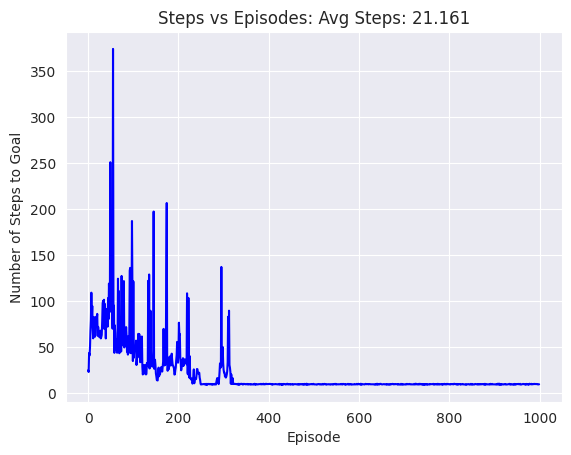

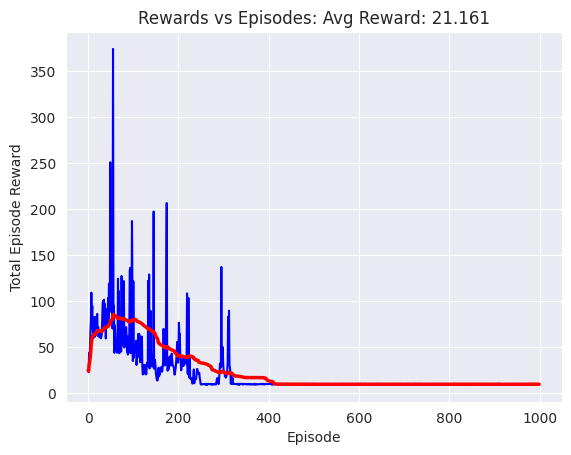

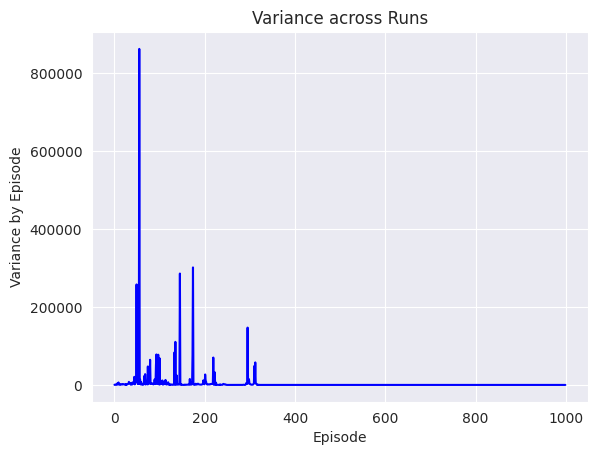

In [17]:
_, _, _ = trainer.plot_results()